# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticLCS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/EllipticLCS")

CPU times: user 111 µs, sys: 100 µs, total: 211 µs
Wall time: 131 µs


# Overview

In the following notebok we extract elliptic LCS in the Agulhas region from the AVISO dataset using a null geodesic identification scheme. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Elliptic LCS:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
   
    * Compute Cauchy Green (CG) strain tensor as: 
    
    \begin{equation} \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0)^T\mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0). \end{equation}
    
    * Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics:
    
    \begin{equation}
    \mathrm{A_{\lambda}(\mathbf{x},t)} = \mathbf{C}_{t_0}^{t_N}(\mathbf{x}) - \lambda^2\mathbf{I}
    \end{equation}
    
    We denote:
    \begin{equation}
    \mathbf{C}_{t_0}^{t_N}(\mathbf{x}) = \begin{pmatrix} C^{11} && C^{12} \\ C^{12} && C^{22}\end{pmatrix}
    \end{equation}
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align*}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A_{\lambda}(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A_{\lambda}(\mathbf{x}) \mathbf{e}_{\phi}(s)}, 
    \end{align*} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $
    
    $  \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evualated through interpolation by first computing $ \nabla_x A_{\lambda}(\mathbf{x}) = \nabla_x C_{t_0}^{t_N}(\mathbf{x}) $ over the meshgrid. 
    
    It holds:
    \begin{equation}
    \dfrac{d \phi}{ds} = - \dfrac{\cos^2(\phi)[C_x^{11}(\mathbf{x})\cos(\phi)+C_y^{11}(\mathbf{x})\sin(\phi)]+[C_x^{12}(\mathbf{x})\cos(\phi)+C_y^{11}(\mathbf{x})\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[C_x^{22}(\mathbf{x})\cos(\phi)+C_y^{22}(\mathbf{x})\sin(\phi)]}{\sin(2\phi)[C^{22}(\mathbf{x})-C^{11}(\mathbf{x})]+2\cos(2\phi)C^{12}(\mathbf{x})}
    \end{equation}
    
    The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mu} = \lbrace (\mathbf{x}_0(\lambda, \phi = 0), 0) \in V: C^{11}(\mathbf{x}_0, t)- \lambda^2 = 0 \rbrace
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}, \phi $ where:
    
   \begin{equation}
   \sin(2\phi)[C^{22}(\mathbf{x})-C^{11}(\mathbf{x})]+2\cos(2\phi)C^{12}(\mathbf{x}) \neq 0
   \label{eq: DOE}
   \end{equation}
   
   If the trajectory violates condition $ \ref{eq: DOE} $, then the integration is stopped. 

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 126 ms, sys: 31.2 ms, total: 158 ms
Wall time: 168 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size
dt = .1

lenT = tN-t0

time = np.arange(t0, tN+dt, dt)

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

# NOTE: As we are computing spatial derivatives of the CG-tensor, the spacing of the meshgrid has to be sufficiently small.
# However, choosing dx to be too small leads to (unnecessary) long computation times.

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 917 µs, sys: 992 µs, total: 1.91 ms
Wall time: 1.01 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 62.6 ms, sys: 16.1 ms, total: 78.8 ms
Wall time: 81.6 ms


# Cauchy Green (CG) strain tensor

The Cauchy Green strain tensor $ C_{t_0}^t(\mathbf{x}) $ is computing by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{5}, \dfrac{1}{10}] $. The computations are parallelized.

In [6]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import Rate of Strain function
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/10]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

def parallel_C(i):
    
    C_parallel = np.zeros((X_domain.shape[1], 2, 2))*np.nan
    
    for j in range(C_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # only compute CG tensor for particles in region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
        
            # Compute gradient of flowmap
            gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
            # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
            gradFmap_t0_tN = gradFmap[:,:,-1]
        
            # Compute CG tensor
            C_parallel[j, :, :] = CauchyGreen(gradFmap_t0_tN)
    
    return C_parallel

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_C)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

CPU times: user 7.23 s, sys: 3.13 s, total: 10.4 s
Wall time: 3min 29s


# Compute Tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute elements of CG tensor
C11 = C[:,:,0,0].copy()
C12 = C[:,:,0,1].copy()
C22 = C[:,:,1,1].copy()
    
# Interpolate elements of CG tensor (per default: linear)
interp_C11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C11, nan=0.0), kx = 1, ky = 1)
interp_C12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C12, nan=0.0), kx = 1, ky = 1)
interp_C22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(C22, nan=0.0), kx = 1, ky = 1)

# Initialize gradients of CG tensor
C11x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C11y = np.zeros((C.shape[0], C.shape[1]))*np.nan
C12x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C12y = np.zeros((C.shape[0], C.shape[1]))*np.nan
C22x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C22y = np.zeros((C.shape[0], C.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]/2
rho_y = aux_grid[1]/2
        
#iterate over meshgrid to compute gradients of CG tensor
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        C11x[i, j] = (interp_C11(x[1], x[0]+rho_x)[0][0]-interp_C11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C11y[i, j] = (interp_C11(x[1]+rho_y, x[0])[0][0]-interp_C11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        C12x[i, j] = (interp_C12(x[1], x[0]+rho_x)[0][0]-interp_C12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C12y[i, j] = (interp_C12(x[1]+rho_y, x[0])[0][0]-interp_C12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        C22x[i, j] = (interp_C22(x[1], x[0]+rho_x)[0][0]-interp_C22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C22y[i, j] = (interp_C22(x[1]+rho_y, x[0])[0][0]-interp_C22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant of phi_phrime (interp_phi_prime) 
# Interpolant indicating domain of existence (= denominator of phi_prime) (interp_DOE)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, C11, C12, C22, C11x, C11y, C12x, C12y, C22x, C22y)

CPU times: user 2.14 s, sys: 4.02 s, total: 6.15 s
Wall time: 1.51 s


# Elliptic LCSs

Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ C_{t_0}^{t_N}(\mathbf{x}_0) − \lambda^2 \mathbf{I} $. $ \lambda ∈ \mathbb{R} $ denotes the averaged tangential stretching over the time-interval $ [t_0, t_N] $ along an elliptic LCS. For perfectly coherent elliptic LCS it holds $ \lambda = 0 $.  

In [9]:
%%time
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics

# extract elliptic LCS from closed null geodesics
from ipynb.fs.defs.elliptic_LCS import _elliptic_LCS

# define lambda range
lam_min = .9
lam_max = 1.1
n_lam = Ncores
lam_range = np.linspace(lam_min, lam_max, n_lam)

# threshold distance between starting and return point of trajectory
d_threshold = 0.02

# compute elliptic LCS
def compute_elliptic_LCS(lam):
    
    # Define list storing x, y coordinates of elliptic LCS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics, init_lam = _closed_null_geodesics(X_domain, Y_domain, lam, interp_phi_prime, d_threshold, C11, interp_DOE)
    
    # Extract elliptic LCS
    x_elliptic, y_elliptic = _elliptic_LCS(closed_null_geodesics)
        
    return [x_elliptic, y_elliptic, init_lam]
        
# conmpute elliptic LCS with parallel computing
Elliptic_LCS = Parallel(n_jobs=Ncores, verbose = 50)(delayed(compute_elliptic_LCS)(lam) for lam in lam_range)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   1 tasks      | elapsed: 19.7min
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed: 20.0min remaining: 160.3min
[Parallel(n_jobs=18)]: Done   3 out of  18 | elapsed: 20.3min remaining: 101.7min
[Parallel(n_jobs=18)]: Done   4 out of  18 | elapsed: 20.6min remaining: 72.1min
[Parallel(n_jobs=18)]: Done   5 out of  18 | elapsed: 20.6min remaining: 53.7min
[Parallel(n_jobs=18)]: Done   6 out of  18 | elapsed: 20.8min remaining: 41.5min
[Parallel(n_jobs=18)]: Done   7 out of  18 | elapsed: 20.9min remaining: 32.8min
[Parallel(n_jobs=18)]: Done   8 out of  18 | elapsed: 21.0min remaining: 26.2min
[Parallel(n_jobs=18)]: Done   9 out of  18 | elapsed: 21.1min remaining: 21.1min
[Parallel(n_jobs=18)]: Done  10 out of  18 | elapsed: 21.2min remaining: 16.9min
[Parallel(n_jobs=18)]: Done  11 out of  18 | elapsed: 21.3min remaining: 13.6min
[Parallel(n_jobs=18)]: Done  12 out of  18 | elap

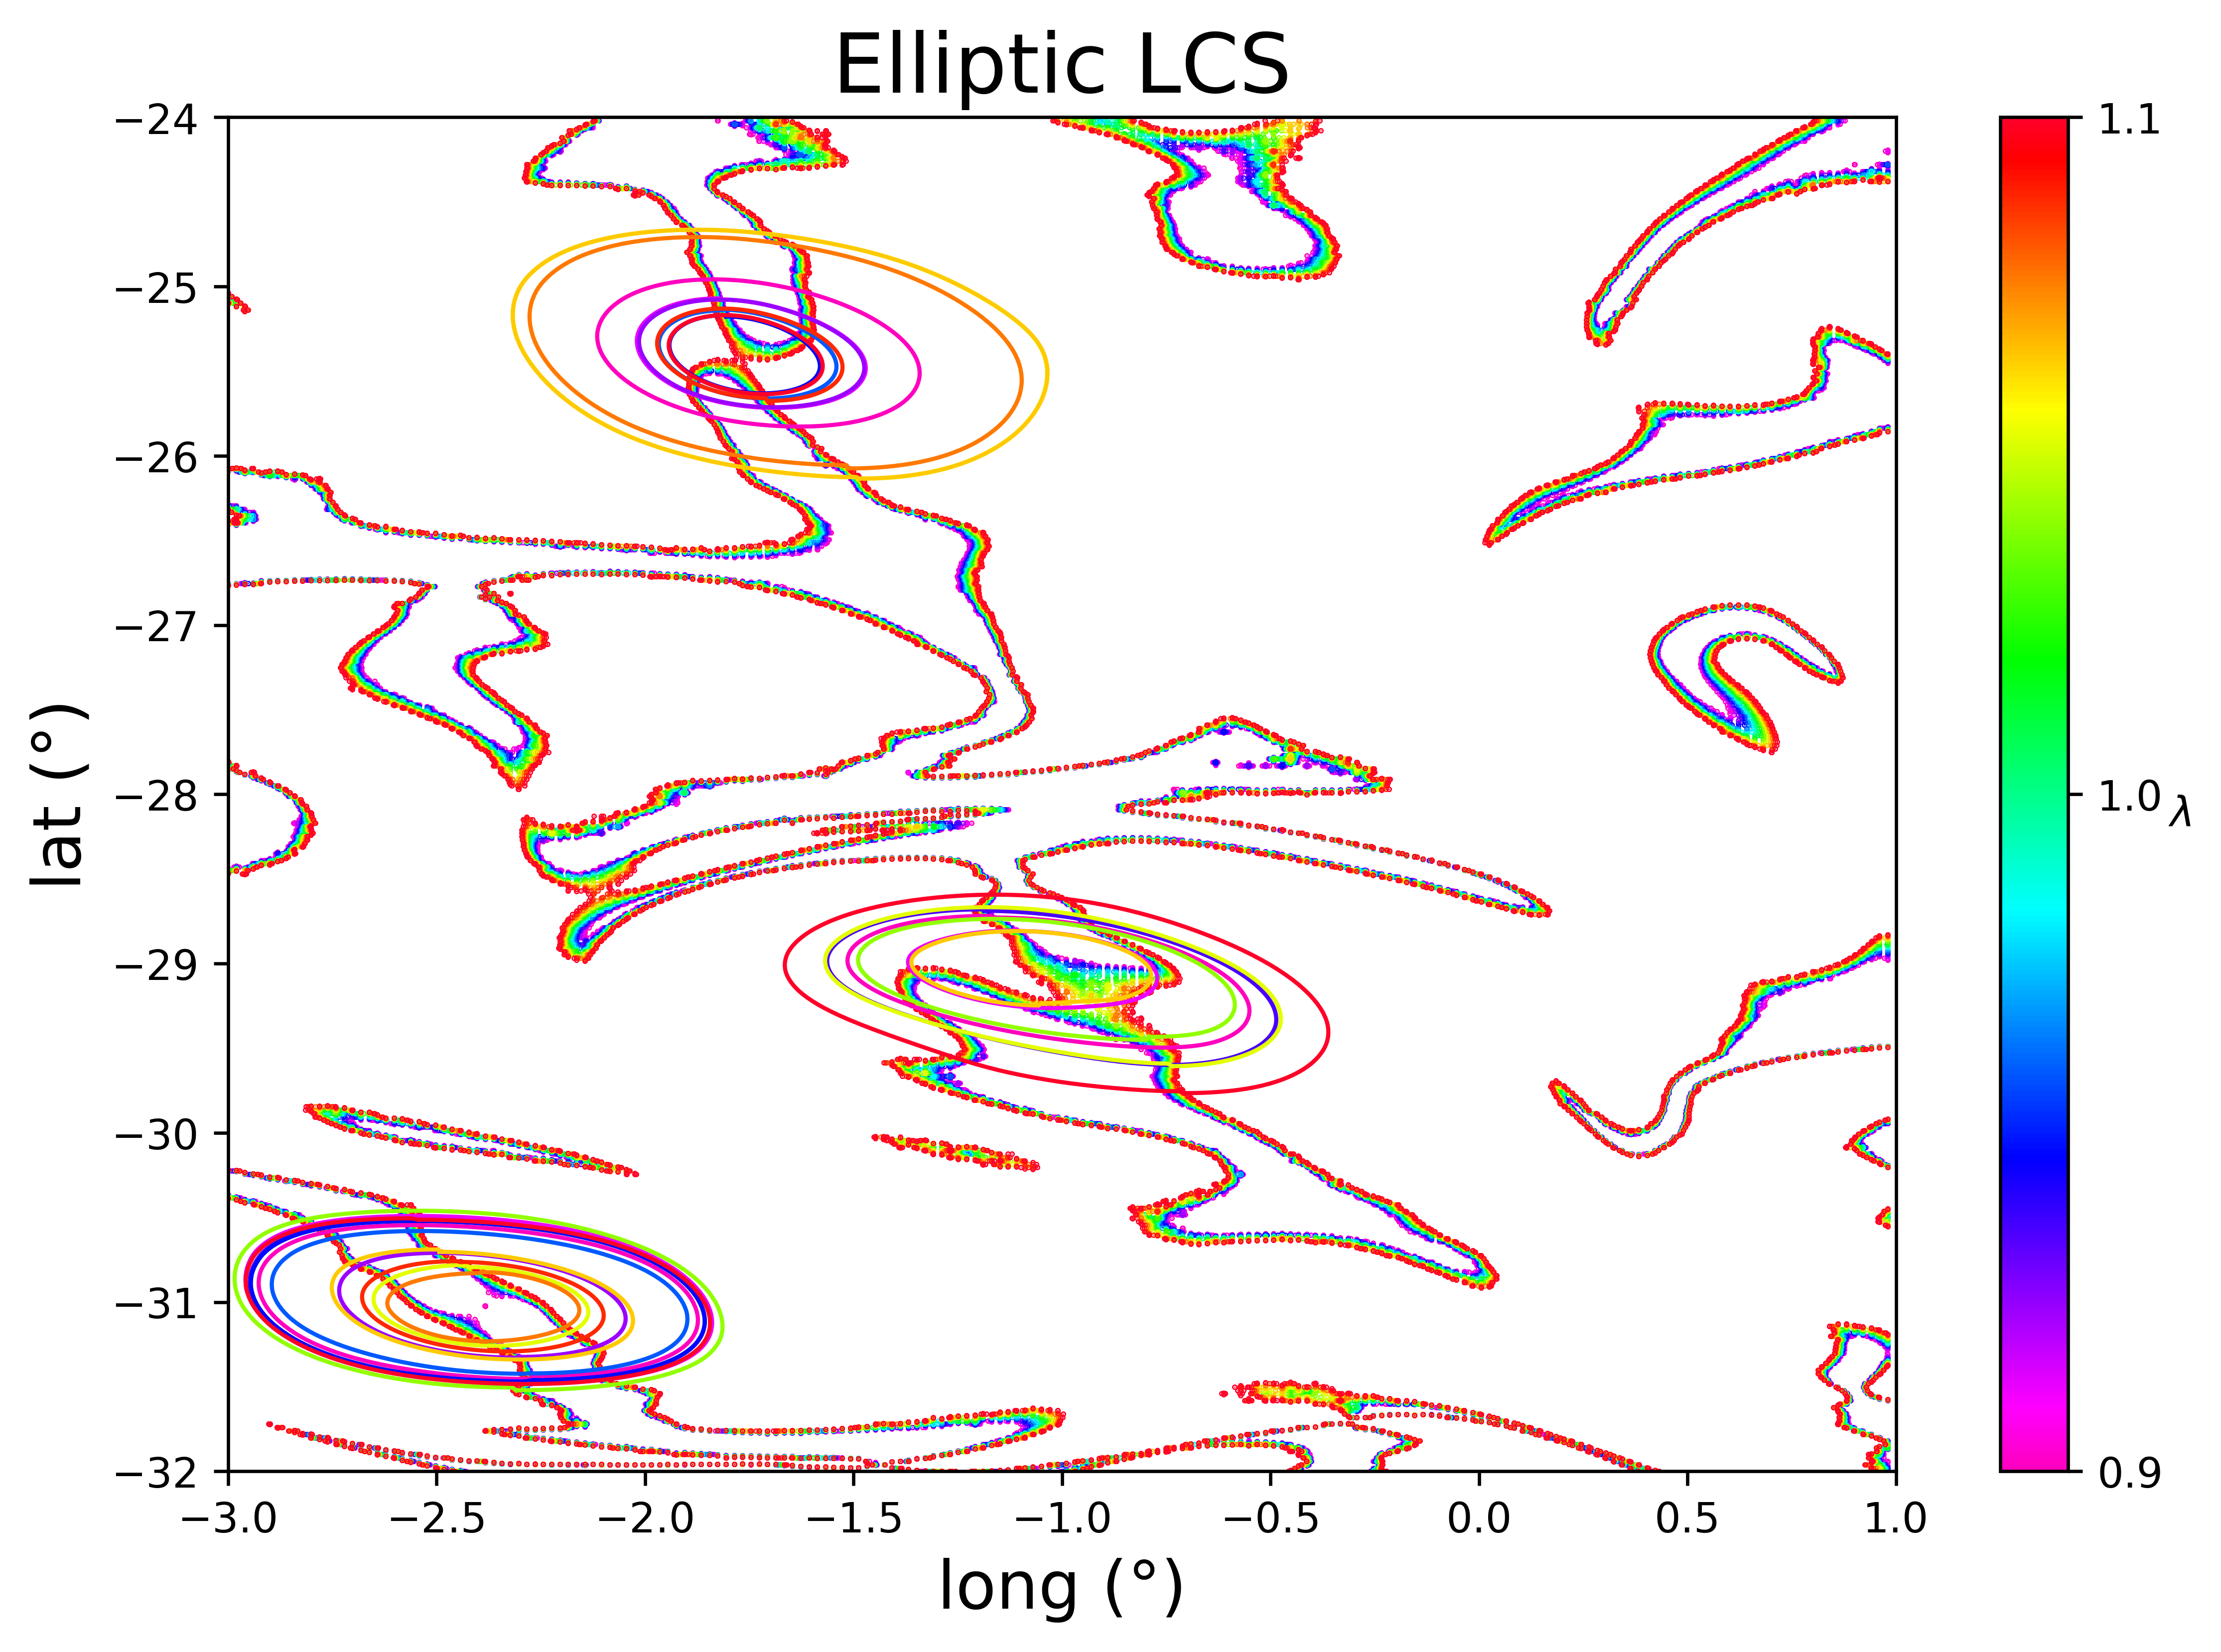

CPU times: user 1.89 s, sys: 55.3 ms, total: 1.94 s
Wall time: 1.94 s


In [10]:
%%time
######################################## Plot elliptic LCS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (9, 6), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LCS and plot
for i in range(len(Elliptic_LCS)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_LCS[i][2][0], Elliptic_LCS[i][2][1], color=cmap.to_rgba(lam_range[i]), s = 0.1)
    
    # Plot elliptic LCS
    if Elliptic_LCS[i][0] is not None:
        for j in range(len(Elliptic_LCS[i][0])):
            if Elliptic_LCS[i][0][j] is not None:
                ax.plot(Elliptic_LCS[i][0][j], Elliptic_LCS[i][1][j], c=cmap.to_rgba(lam_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lam_range.min(), 1, lam_range.max()])
cbar.ax.set_ylabel(r'$ \lambda $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Elliptic LCS", fontsize = 20)
plt.show();

We obtain three objectively detected elliptic LCS families. The (colored) closed curves indicate elliptic LCS for different values of $ \lambda $. Furthermore, the initial conditions $ \mathbf{x}_0(\lambda, \phi_0 = 0) $ are also plotted as a function of $ \lambda $ (see colormap).

# Advect Elliptic LCS

We now advect the computed elliptic LCS over a period of 25 days. The colored dashed lines denote the elliptic OECS computed at $ t_0 = 0$, whereas the colored solid lined indicate the same elliptic LCS advected after 25 days. As expected the detected elliptic LCS show coherent behaviour even after advection and barely deform.

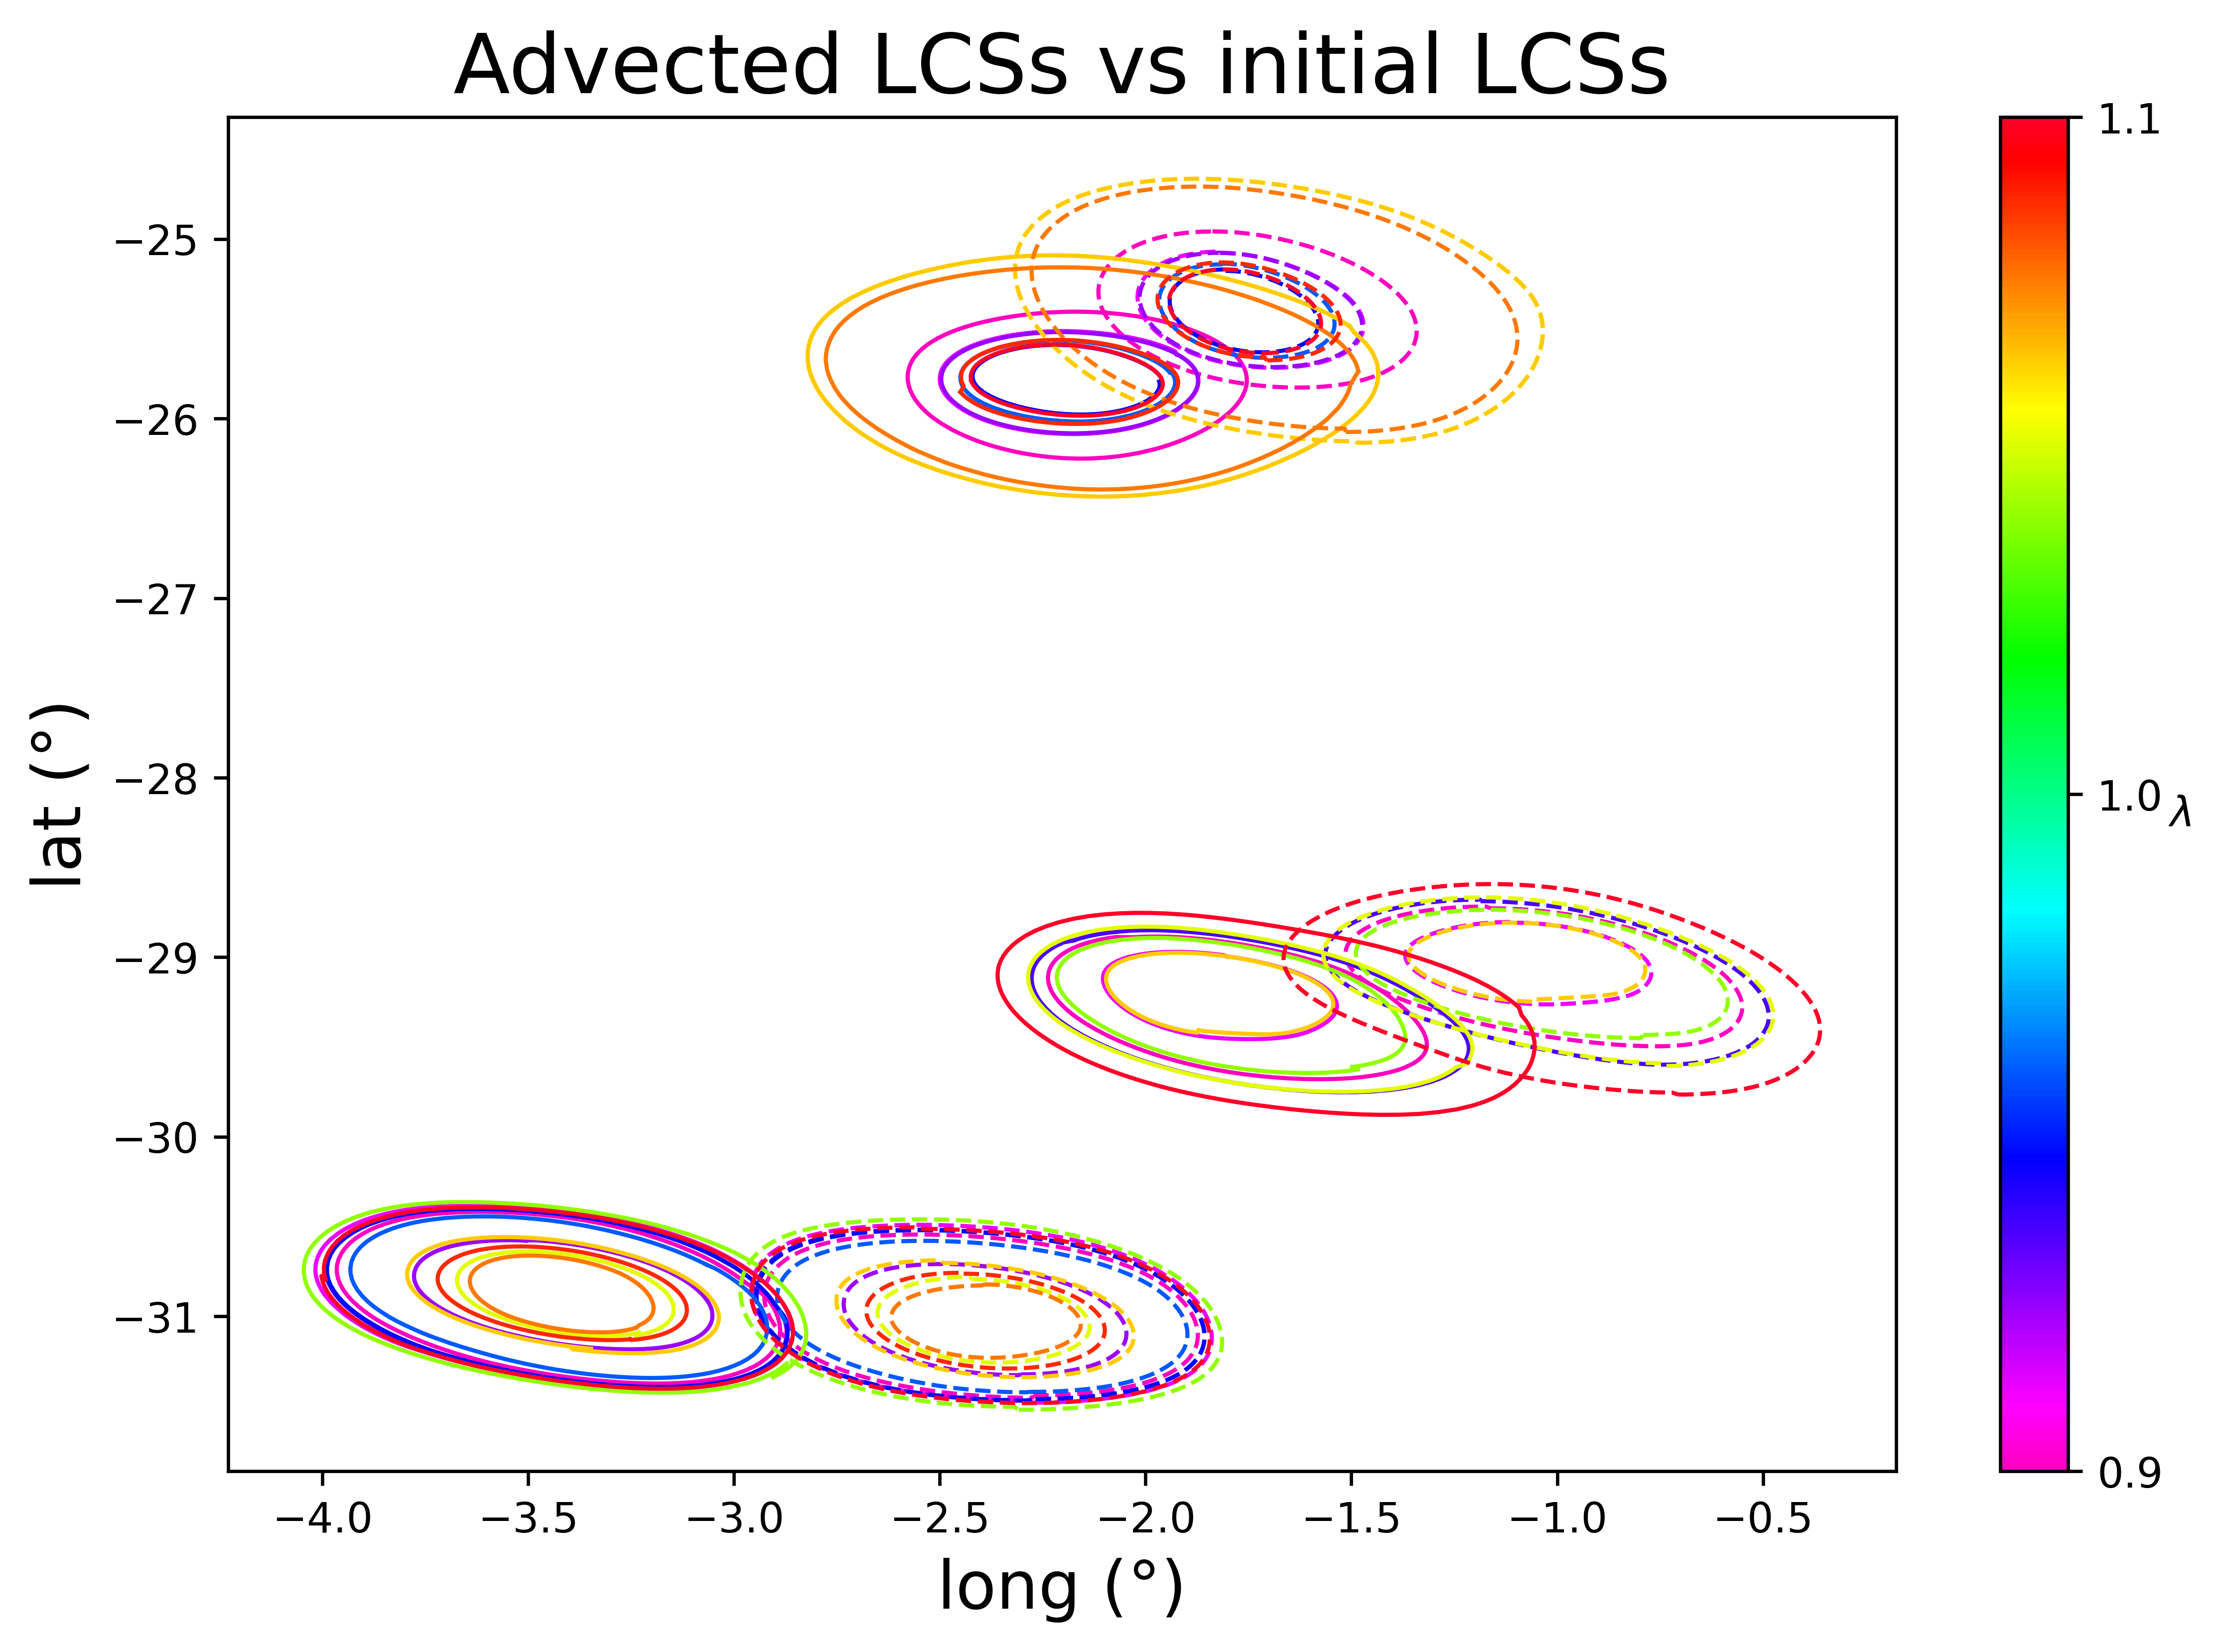

In [11]:
# Import package for computing trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# define time-horizon over which to advect
time_advect = time.copy()

# Define figure/axes
fig = plt.figure(figsize = (9, 6), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LCS and plot
for i in range(len(Elliptic_LCS)):
    # dummy plot
    ax.scatter(np.nan, np.nan, s = 1, color=cmap.to_rgba(lam_range[i]))
    if Elliptic_LCS[i][0] is not None:
        for j in range(len(Elliptic_LCS[i][0])):
            if Elliptic_LCS[i][0][j] is not None:
                ax.plot(Elliptic_LCS[i][0][j], Elliptic_LCS[i][1][j], c=cmap.to_rgba(lam_range[i]), linewidth = 1, linestyle = "dashed")
                
                x_advected, y_advected = [], []
                
                # advect Elliptic LCS
                for t in range(len(Elliptic_LCS[i][0][j])):
                    
                    x = np.array([Elliptic_LCS[i][0][j][t], Elliptic_LCS[i][1][j][t]])
                    
                    # Advect LCS over 25 days
                    Fmap = integration_dFdt(time_advect, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]

                    # extract end-point of advection
                    x_end = Fmap[:,-1]
                    
                    x_advected.append(x_end[0])
                    y_advected.append(x_end[1])
                    
                ax.plot(x_advected, y_advected, c=cmap.to_rgba(lam_range[i]), linewidth = 1)
                
# Set axis labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lam_range.min(), 1, lam_range.max()])
cbar.ax.set_ylabel(r'$ \lambda $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Advected LCSs vs initial LCSs", fontsize = 20)
plt.show();

# Find outermost closed curve for each family of elliptic LCS

We now seek to find the outermost elliptic LCS within each family of elliptic LCSs. The extracted (outermost) elliptic LCSs are plotted together with the FTLE.

In [12]:
# add FTLE folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE")

# Import function for computing FTLE
from ipynb.fs.defs.FTLE import _FTLE

# import function which extracts outermost elliptic LCS for each family of elliptic LDB
from ipynb.fs.defs.find_outermost_closed_curve import find_outermost_closed_curve

# find outermost elliptic LCS in each family of elliptic LCS
x_outermost_elliptic_LCS, y_outermost_elliptic_LCS, lambda_outermost_elliptic_LCS = find_outermost_closed_curve(Elliptic_LCS, lam_range)

# initialize FTLE
FTLE = C[:,:,0,0].copy()*np.nan

# compute FTLE field
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        FTLE[i, j] = _FTLE(C[i, j, :, :], lenT)

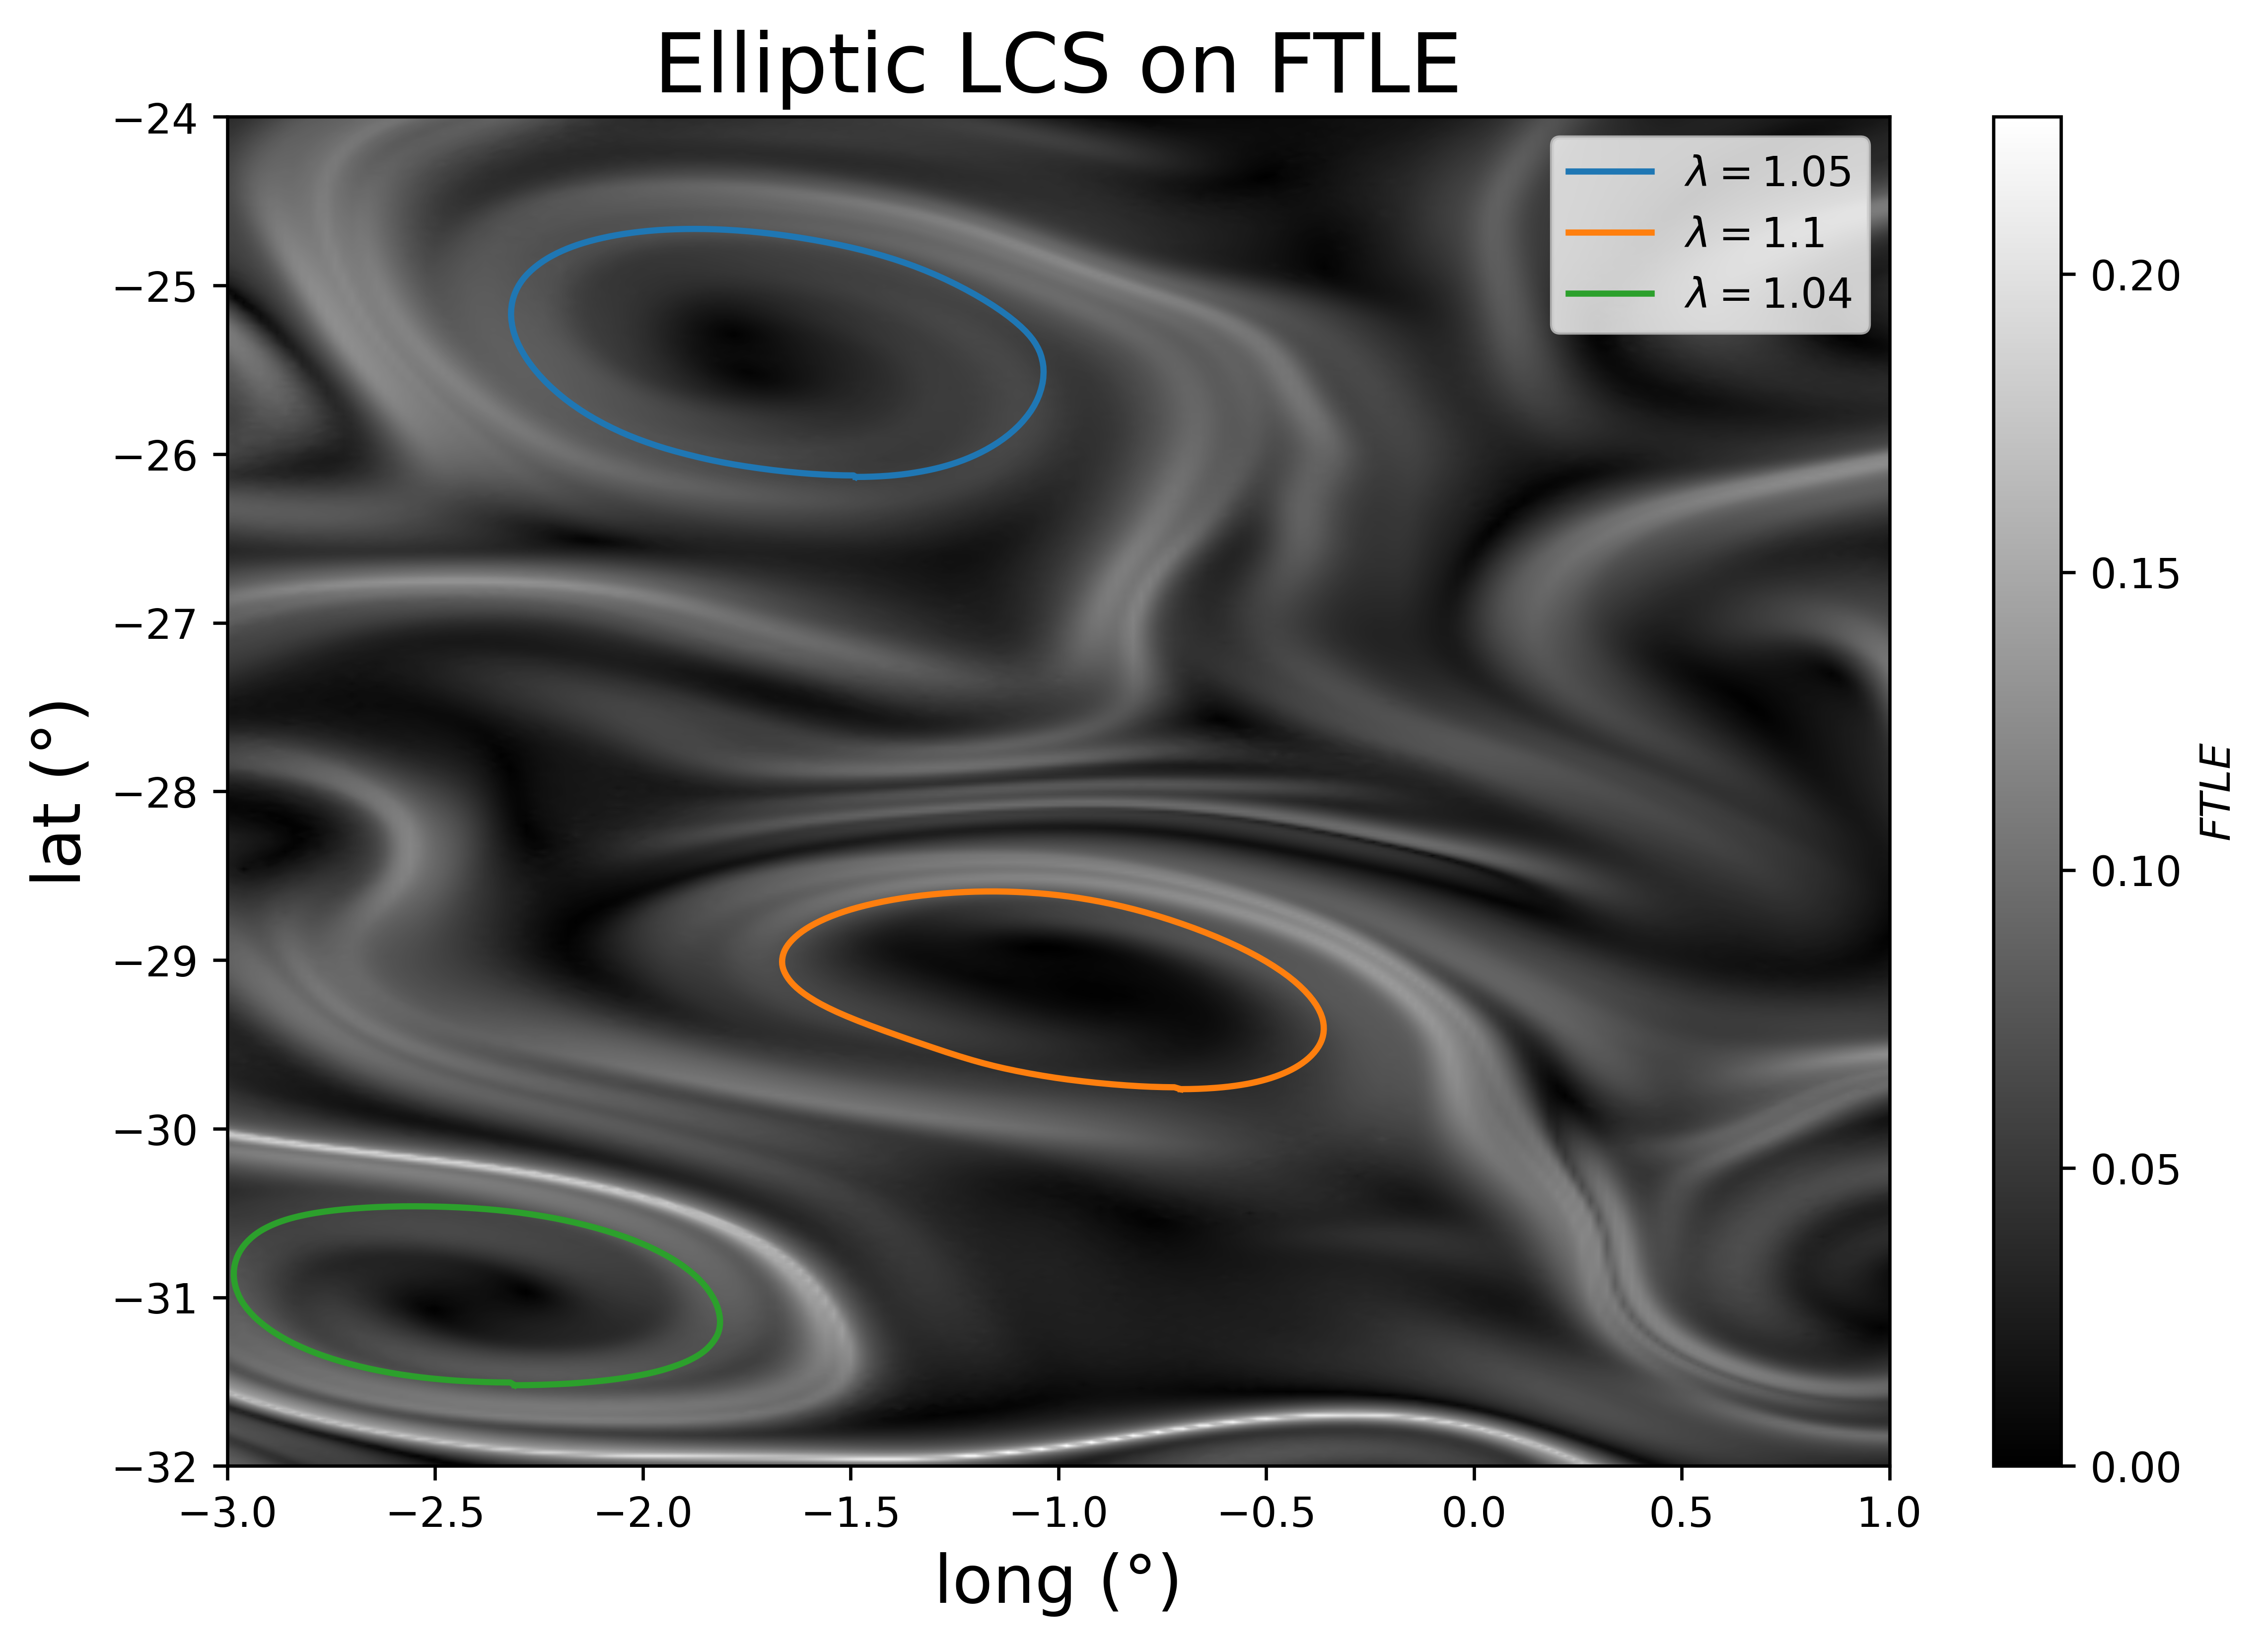

CPU times: user 3.57 s, sys: 42.5 ms, total: 3.61 s
Wall time: 3.61 s


In [13]:
%%time
######################################## Plot outermost elliptic LCS on top of FTLE ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (9, 6), dpi = 600)
ax = plt.axes()

# Iterate over all outermost elliptic LCS and plot
for i in range(len(x_outermost_elliptic_LCS)):
    
    ax.plot(x_outermost_elliptic_LCS[i], y_outermost_elliptic_LCS[i], label = r'$ \lambda = $' + str(np.around(lambda_outermost_elliptic_LCS[i], 2)))
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

cax = ax.contourf(X_domain, Y_domain, FTLE, cmap = "gist_gray", levels = 600)

# Colorbar of FTLE
cbar = fig.colorbar(cax, ticks = np.arange(0, 0.4, 0.05))
cbar.ax.set_ylabel(r'$ FTLE $', rotation = 90, fontsize = 10)

# Title
ax.set_title("Elliptic LCS on FTLE", fontsize = 20)

plt.legend(loc = "upper right")
plt.show();

# References

[1] Serra, M., & Haller, G. (2017). Efficient computation of null geodesics with applications to coherent vortex detection. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 473(2199).